In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task
from collections import defaultdict
from typing import Dict

## Block 1

In [2]:
py_filepath = "/home/INT/losada.c/Documents/data/test/lip/lip/2022-11-22_10-59-03_Riesling_lip_e1_r1.npy"
#2022-12-14_10-50-49_Riesling_lip_e1_r1  2022-11-22_10-59-03_Riesling_lip_e1_r1

#### Load file

In [3]:
py_f = np.load(py_filepath,allow_pickle=True).item(0)
sp_py = py_f['sp_data']
bhv = py_f['bhv']
print('sp_py keys:')
print(sp_py.keys())
print('bhv_py trial keys:')
print(bhv[0].keys())

sp_py keys:
dict_keys(['sp_samples', 'blocks', 'code_numbers', 'code_samples', 'eyes_values', 'lfp_values', 'samples', 'clusters_id', 'clusters_ch', 'clustersgroup', 'clusterdepth'])
bhv_py trial keys:
dict_keys(['trial', 'AbsoluteTrialStartTime', 'Btn1', 'Btn10', 'Btn2', 'Btn3', 'Btn4', 'Btn5', 'Btn6', 'Btn7', 'Btn8', 'Btn9', 'Eye', 'Eye2', 'EyeExtra', 'Gen1', 'Gen10', 'Gen11', 'Gen12', 'Gen13', 'Gen14', 'Gen15', 'Gen16', 'Gen2', 'Gen3', 'Gen4', 'Gen5', 'Gen6', 'Gen7', 'Gen8', 'Gen9', 'Joystick', 'Joystick2', 'KeyInput', 'Mouse', 'PhotoDiode', 'SampleInterval', 'Touch', 'CodeNumbers', 'CodeTimes', 'Block', 'BlockCount', 'Condition', 'CycleRate', 'Angle', 'BackgroundColor', 'Info', 'Position1', 'Position2', 'Position3', 'Position4', 'Position5', 'Position6', 'Scale', 'Status', 'Time', 'Zorder', 'ReactionTime', 'EndTimes', 'StartTimes', 'Attribute11', 'Attribute12', 'Attribute13', 'Attribute21', 'Attribute22', 'Attribute23', 'Attribute24', 'Attribute25', 'Attribute26', 'Code', 'FrameByF

In [4]:
# Selec trials in a block
n_block = 1
trial_idx = select_trials.select_trials_block(sp_py,n_block)
# Selec correct trials
trial_idx = select_trials.select_correct_trials(bhv,trial_idx)
b_sp_samples = [sp_py['sp_samples'][i] for i in trial_idx]
print('Number of clusters: %d'%len(b_sp_samples[0]))

Number of trials in block 1: 1308
Number of correct trials in block 2: 574
Number of clusters: 16


In [5]:
# sample identity
# IN:
# A: (1o 1c) 1 - 7
# B: (1o 5c) 8 - 14
# C: (5o 1c) 15 - 21
# D: (5o 5c) 22 - 28 

In [35]:
samples_cond = {
    # samples IN
    'o1_c1_in' : np.arange(1,8),
    'o1_c5_in' : np.arange(8,15),
    'o5_c1_in' : np.arange(15,22),
    'o5_c5_in' : np.arange(22,29),
}

In [36]:
def test_stim(task,bhv_idx):
    for key,value in bhv_idx.items():
        if 'Stim_Filename_' in key:
            val = value.item(0).decode('utf-8')
            if key[-1] == 'd': # distractor
                task['test_stimuli_'+key[-2:]] += [val[-11:-10]+val[-9:-6]+val[-5:-4]]
            else:
                task['test_stimuli_'+key[-1]] += [val[-11:-10]+val[-9:-6]+val[-5:-4]]
                n_test =  int(key[-1])

    for n in range(n_test+1,6):
        task['test_stimuli_'+str(n)] += ['']
        task['test_stimuli_'+str(n)+'d'] += ['']

    return task,n_test

In [37]:
def create_task_frame(trial_idx,bhv,samples_cond):
    task:Dict[str,list] = defaultdict(list)#{}
    for idx in trial_idx:
        task['idx_trial'] += [idx]
        cond = int(bhv[idx]['Condition'][0][0])
        o1_c1_out = samples_cond['o1_c1_in']+28
        o1_c5_out = samples_cond['o1_c5_in']+28
        o5_c1_out = samples_cond['o5_c1_in']+28
        o5_c5_out = samples_cond['o5_c5_in']+28
        # IN
        if cond in samples_cond['o1_c1_in']:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'o1_c1'
            code = 7- (samples_cond['o1_c1_in'][-1]-cond)
            if code == 7:
                sample_id = 'o0_c0'
            task['sample_id'] += [sample_id]
            task['in_out'] += [1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in samples_cond['o1_c5_in']:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'o1_c5'
            code = 7- (samples_cond['o1_c5_in'][-1]-cond)
            if code == 7:
                sample_id = 'o0_c0'
            task['sample_id'] += [sample_id]
            task['in_out'] += [1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in samples_cond['o5_c1_in']:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'o5_c1'
            code = 7- (samples_cond['o5_c1_in'][-1]-cond)
            if code == 7:
                sample_id = 'o0_c0'
            task['sample_id'] += [sample_id]
            task['in_out'] += [1]    
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in samples_cond['o5_c5_in']:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'o5_c5'
            code = 7- (samples_cond['o5_c5_in'][-1]-cond)
            if code == 7:
                sample_id = 'o0_c0'
            task['sample_id'] += [sample_id]
            task['in_out'] += [1]    
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        # OUT
        elif cond in o1_c1_out:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'o1_c1'
            code = 7- (o1_c1_out[-1]-cond)
            if code == 7:
                sample_id = 'o0_c0'
            task['sample_id'] += [sample_id]
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in o1_c5_out:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'o1_c5'
            code = 7- (o1_c5_out[-1]-cond)
            if code == 7:
                sample_id = 'o0_c0'
            task['sample_id'] += [sample_id]
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in o5_c1_out:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'o5_c1'
            code = 7- (o5_c1_out[-1]-cond)
            if code == 7:
                sample_id = 'o0_c0'
            task['sample_id'] += [sample_id]
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]
        elif cond in o5_c5_out:
            task,n_test = test_stim(task,bhv[idx])
            sample_id = 'o5_c5'
            code = 7- (o5_c5_out[-1]-cond)
            if code == 7:
                sample_id = 'o0_c0'
            task['sample_id'] += [sample_id]
            task['in_out'] += [-1]
            task['n_test_stimuli'] += [n_test]
            task['code'] += [code]

    return pd.DataFrame(task)

In [38]:
task=create_task_frame(trial_idx,bhv,samples_cond)

In [51]:
def info_task(task):
    fig,ax = plt.subplots(1,2,figsize=(10,4))
    data = task[['sample_id','in_out']].groupby(['sample_id','in_out'],as_index=False).size()
    sns.barplot(data=data,x='sample_id',y='size',hue='in_out',ax=ax[0])
    data = task[(task['in_out']==1)&(task['sample_id']!='o0_c0')][['sample_id','n_test_stimuli']].groupby(['sample_id','n_test_stimuli'],as_index=False).size()
    sns.barplot(data=data,x='sample_id',y='size',hue='n_test_stimuli',ax=ax[1])
    data = task.groupby(task.drop(['idx_trial','test_stimuli_1d','test_stimuli_2d','test_stimuli_3d','test_stimuli_4d','test_stimuli_5d'],inplace=False,axis=1).columns.to_list(),as_index=False).size()
    data=data[data['size']>1].replace('',float(np.nan))
    data.dropna(how='all',axis=1,inplace=True)
    data.sort_values(by=['sample_id','code','size'])
    return fig,data

,test_stimuli_1,test_stimuli_2,test_stimuli_3,sample_id,in_out,n_test_stimuli,code,size
0,o1_c1,NaN,NaN,o1_c1,-1,1,1,19
1,o1_c1,NaN,NaN,o1_c1,1,1,1,18
15,o1_c1,o5_c5,NaN,o5_c5,1,2,2,2
16,o1_c1,o5_c6,o5_c1,o5_c1,-1,3,3,2
17,o1_c1,o5_c6,o5_c5,o5_c5,1,3,3,2
58,o1_c5,NaN,NaN,o1_c5,-1,1,1,13
59,o1_c5,NaN,NaN,o1_c5,1,1,1,13
60,o1_c5,o1_c1,NaN,o1_c1,-1,2,2,2
61,o1_c5,o1_c1,NaN,o1_c1,1,2,2,4
79,o1_c6,o1_c1,NaN,o1_c1,1,2,2,3


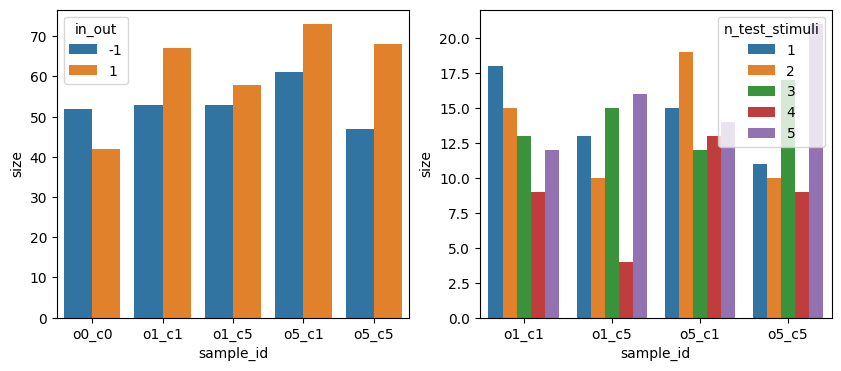

In [52]:
fig,data = info_task(task)
data

In [41]:

# kernel parameters

w = 0.015 # seconds = 15 ms
w_size = 0.1 # seconds = 100ms

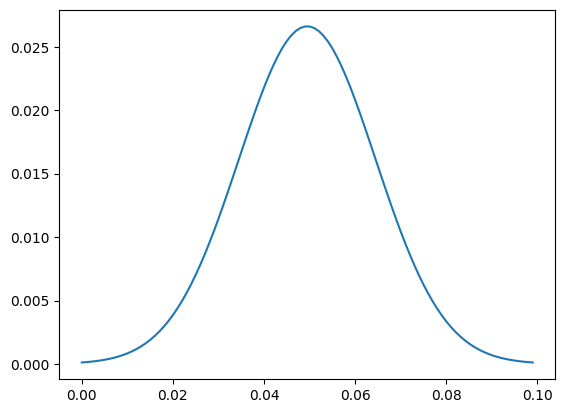

In [42]:
# define kernel for the convolution
fs_ds = config.FS/config.DOWNSAMPLE
kernel = signal.gaussian(M=w_size*fs_ds,std=w*fs_ds)
kernel=kernel/sum(kernel) # area of the kernel must be one
plt.plot(np.arange(len(kernel))/fs_ds,kernel)

In [43]:
events = {
    'start_trial':9,
    'fixation':8,
    'sample_on': 23,
    'sample_off': 24,
    'test_on_1': 25, 
    'test_off_1':26,
    # 'test_on_2': 27, 
    # 'test_off_2':28,
    # 'test_on_3': 29, 
    # 'test_off_3':30,
    # 'test_on_4': 31, 
    # 'test_off_4':32,
    # 'test_on_5': 33, 
    # 'test_off_5':34,
    'end_trial':18,
}

#### Check sample selectiviy


In [46]:
palette={'o1_c1': 'firebrick', 'o1_c5': 'teal', 'o5_c1': 'tomato', 'o5_c5': 'turquoise', 'o0_c0': 'grey'}

In [47]:
task

,idx_trial,test_stimuli_1,test_stimuli_1d,test_stimuli_2,test_stimuli_2d,test_stimuli_3,test_stimuli_3d,test_stimuli_4,test_stimuli_4d,test_stimuli_5,test_stimuli_5d,sample_id,in_out,n_test_stimuli,code
0,105,o5_c8,o8_c8,o7_c4,o2_c2,o4_c5,o1_c1,o5_c2,o6_c3,o5_c5,o7_c6,o5_c5,1,5,5
1,111,o5_c2,o5_c7,o5_c5,o8_c5,,,,,,,o5_c5,-1,2,2
2,113,o5_c5,o5_c6,o1_c4,o7_c3,o5_c1,o8_c8,,,,,o5_c1,1,3,3
3,114,o5_c4,o5_c6,o5_c5,o6_c3,,,,,,,o5_c5,1,2,2
4,116,o8_c7,o6_c2,o5_c1,o7_c4,,,,,,,o5_c1,-1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,1385,o3_c1,o8_c3,o1_c5,o7_c7,o1_c1,o4_c5,,,,,o1_c1,-1,3,3
570,1387,o5_c5,o1_c2,o6_c5,o4_c7,o4_c6,o7_c6,o1_c8,o5_c7,o1_c5,o7_c1,o1_c5,-1,5,5
571,1391,o5_c1,o6_c7,o1_c4,o1_c7,o4_c5,o1_c1,o5_c1,o8_c3,o1_c2,o5_c2,o1_c5,-1,5,6
572,1393,o1_c4,o8_c4,o8_c2,o5_c2,o1_c5,o8_c8,,,,,o1_c5,1,3,3


In [49]:
def mean_fr_by_sample(sp_py,task,samples,events,neurons,in_out,e_align,fs,downsample=1,plot=True,x_lim_min=-0.7,x_lim_max=5):
    fs_ds = fs/downsample
    fr_samples:Dict[str,list] = defaultdict(list)
    neuron_max_shift = np.zeros(len(neurons))
    for i,neuron in enumerate(neurons):

        fig,ax = plt.subplots(figsize=(10, 6),sharex=True,sharey=True)
        sample_id = task[(task['in_out']==in_out)]['sample_id'].values
        target_trials_idx = task[(task['in_out']==in_out)]['idx_trial'].values
        # events
        ev_ts = firing_rate.select_events_timestamps(sp_py,target_trials_idx, events) # select events timestamps for all trials
        shift_ev_ts = np.floor(((ev_ts.T-ev_ts.T[0]).T)/downsample)
        # sp
        neuron_trials = firing_rate.align_neuron_spikes(target_trials_idx, sp_py, neuron, ev_ts[:,0])# set the 0 at the event start trial
        trials_sp = firing_rate.sp_from_timestime_to_binary(neuron_trials, downsample)

        sp_shift, max_shift, events_shift = firing_rate.reshape_sp_list(trials_sp, event_timestamps=shift_ev_ts, align_event=e_align)

        conv= firing_rate.compute_fr(neuron_trials,kernel,fs/downsample,downsample)
        all_trials_fr,_,_ = firing_rate.aligne_conv_fr(conv=conv,event_timestamps=shift_ev_ts,align_event=e_align)
        neuron_max_shift[i] = int(max_shift)
        ax2 = ax.twinx()
        for i_s, i_sample in enumerate(samples):
            mask_sample = sample_id==i_sample
            sp_sample = sp_shift[mask_sample,:]
            conv_sample = all_trials_fr[mask_sample,:]
            #ev_sample = shift_ev_ts[mask_sample]
            # save in dict
            for t in np.arange(sp_sample.shape[1]):
                fr_samples['t'+str(t)] += sp_sample[:,t].tolist()
            fr_samples['neuron'] += [i+1]*len(sp_sample)
            fr_samples['sample'] += [i_sample]*len(sp_sample)
            fr_samples['trial_idx'] += target_trials_idx[mask_sample].tolist()
            
            all_trials_mean_fr = np.mean(conv_sample, axis=0)
            ax.plot((np.arange(len(all_trials_mean_fr)) - max_shift)/fs_ds , all_trials_mean_fr,color= palette[i_sample])
            
        events_shift = np.mean(events_shift,axis=0)-max_shift
        conv_max = int(np.floor(max(np.mean(all_trials_fr,axis=0))) + 2)
        num_trials = len(neuron_trials)
        lineoffsets = np.arange(conv_max, num_trials*0.2 + conv_max)
        neuron_trials_shift = firing_rate.align_neuron_spikes(target_trials_idx, sp_py, neuron, ev_ts[:,2])/downsample # align sp with stim onset
        ax2.eventplot(neuron_trials_shift / fs_ds, color=".2", lineoffsets=0.2, linewidths=0.5)
        # events
        ax.vlines(
            events_shift[1] / fs_ds, 0, lineoffsets[-1], color="k", linestyles="dashed"
        )  #Fixation
        ax.vlines(
            events_shift[2] / fs_ds, 0, lineoffsets[-1], color="b", linestyles="dashed"
        )  # Sample on
        ax.vlines(
            events_shift[3] / fs_ds, 0, lineoffsets[-1], color="k", linestyles="dashed"
        )  # Sample off
        ax.vlines(
            events_shift[4] / fs_ds, 0, lineoffsets[-1], color="k", linestyles="dashed"
        ) # test on
        ax.vlines(
            events_shift[5] / fs_ds, 0, lineoffsets[-1], color="k", linestyles="dashed"
        )# test off

        ax.set(xlabel="Time (s)", ylabel="Average firing rate")
        ax2.set(xlabel="Time (s)", ylabel="trials")
        ax2.set_yticks(range(-conv_max, int(num_trials*0.2)))
        ax.set_title('in_out: %d'%(in_out))
        ax.set_xlim(x_lim_min, x_lim_max)
        plt.setp(ax2.get_yticklabels(), visible=False)
        fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
        fig.legend(['Sample o1_c1','Sample o1_c5','Sample o5_c1','Sample o5_c5','Sample o0_c0','Fixation','Sample on','Sample off','Test on','Test off'], fontsize=9)
        fig.suptitle("Neuron %d" % (i + 1), x=0)
        plt.show()
            
    fr_samples=pd.DataFrame(fr_samples)
    return fr_samples,neuron_max_shift


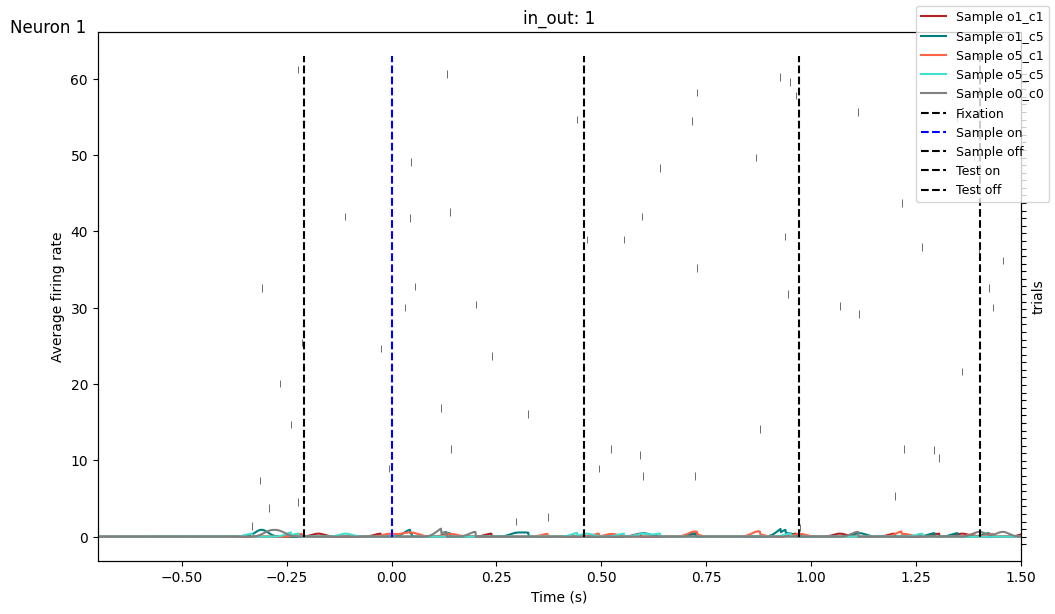

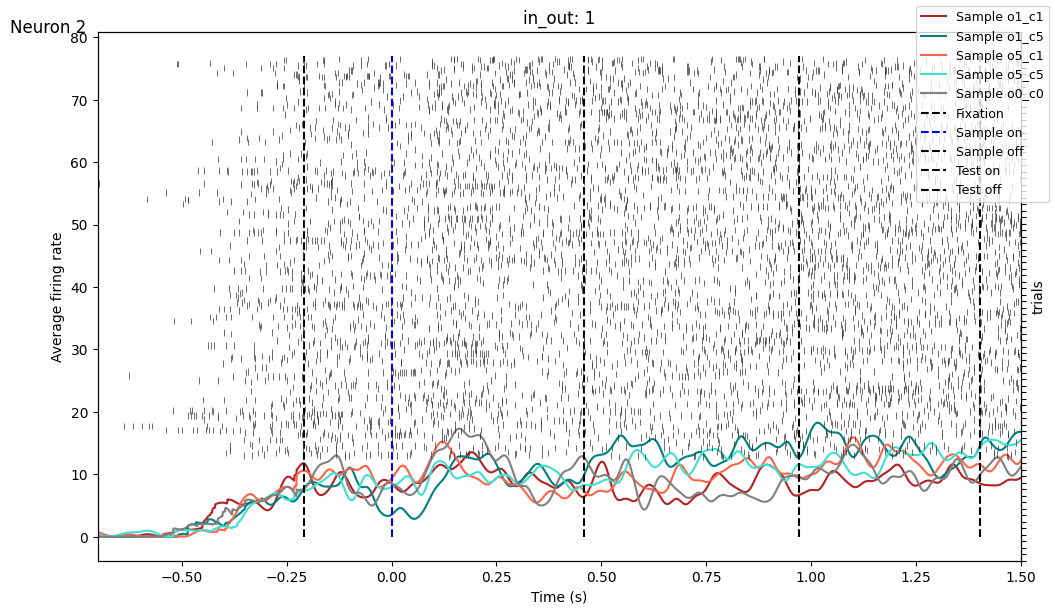

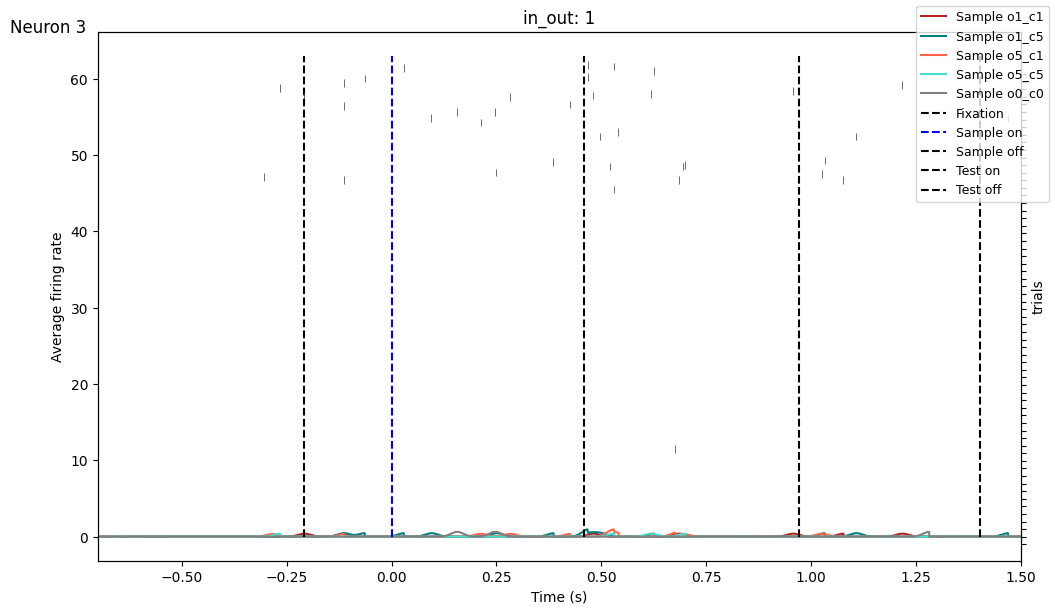

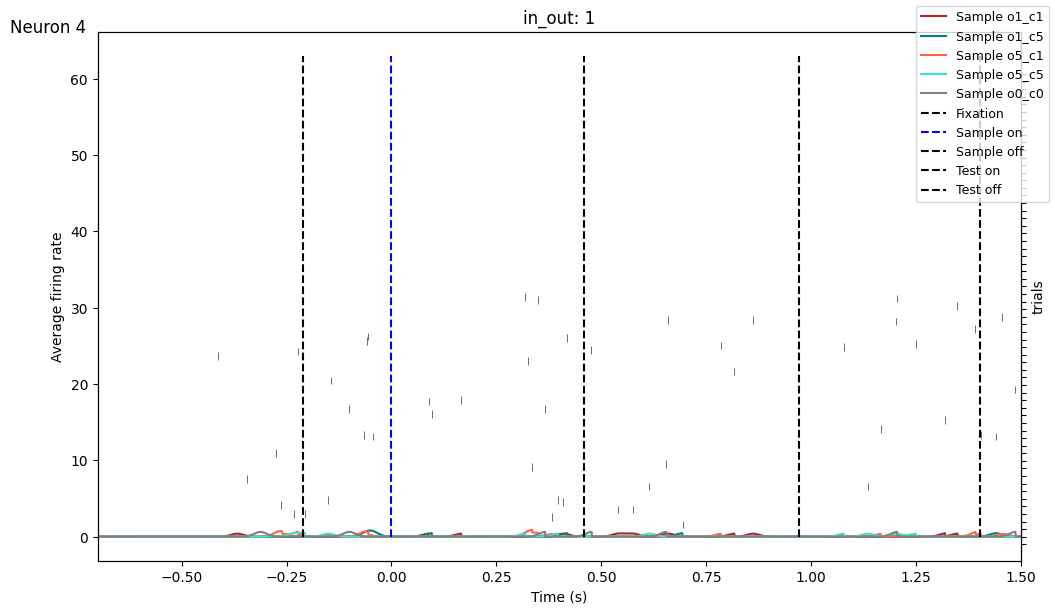

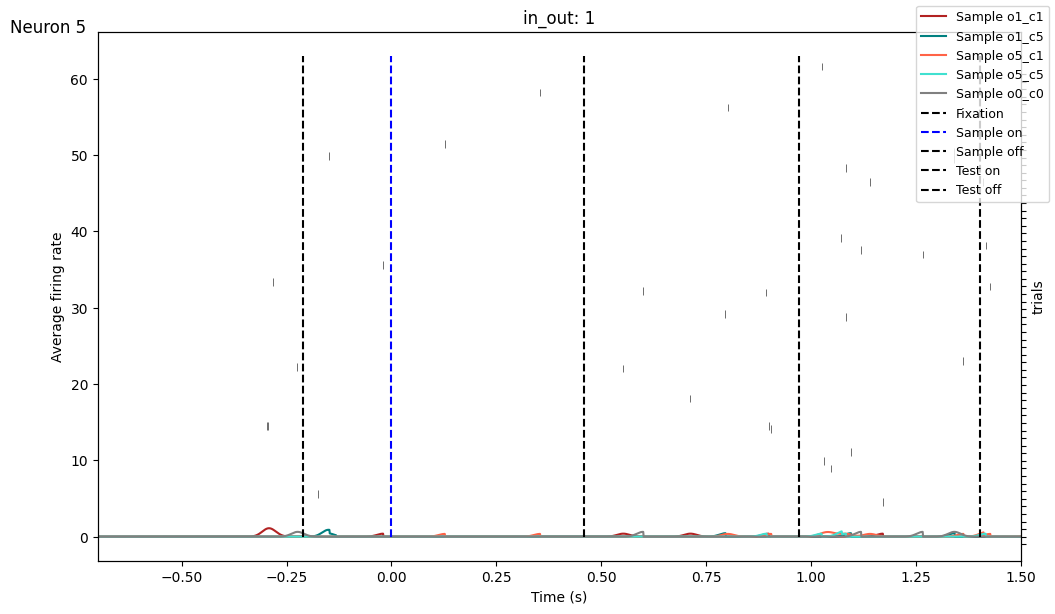

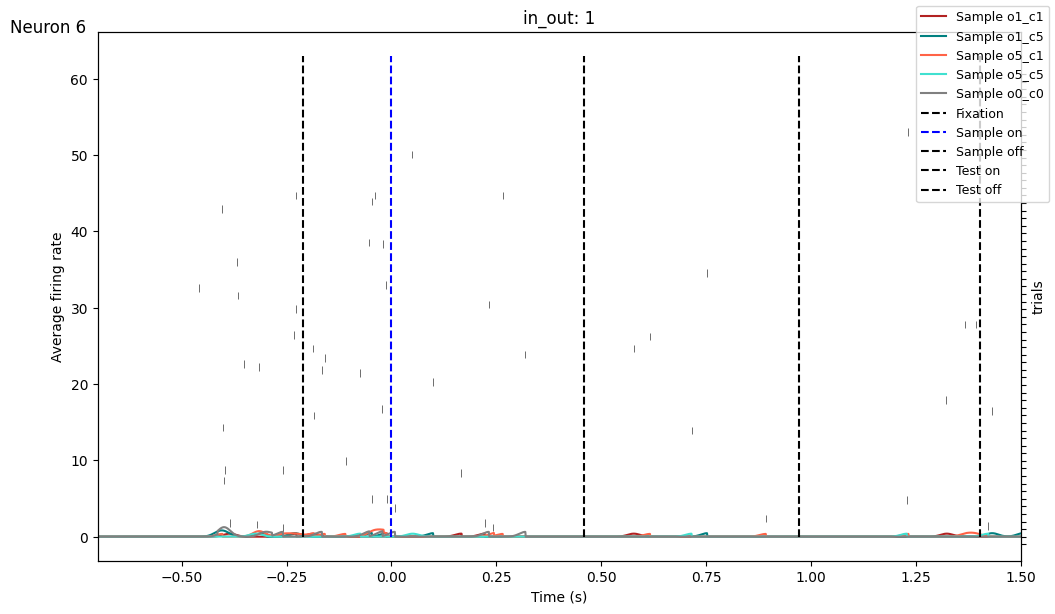

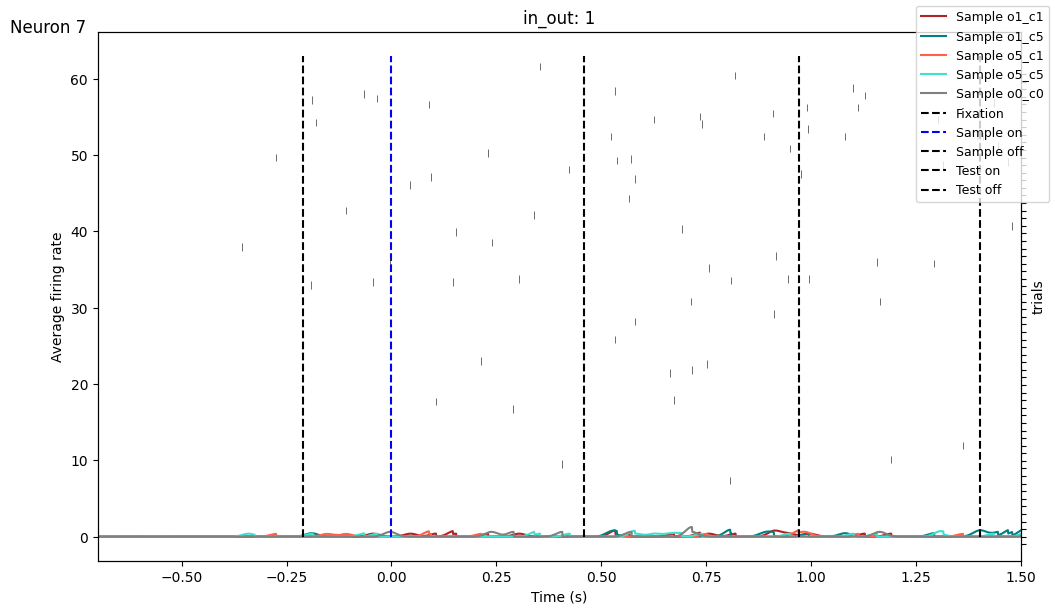

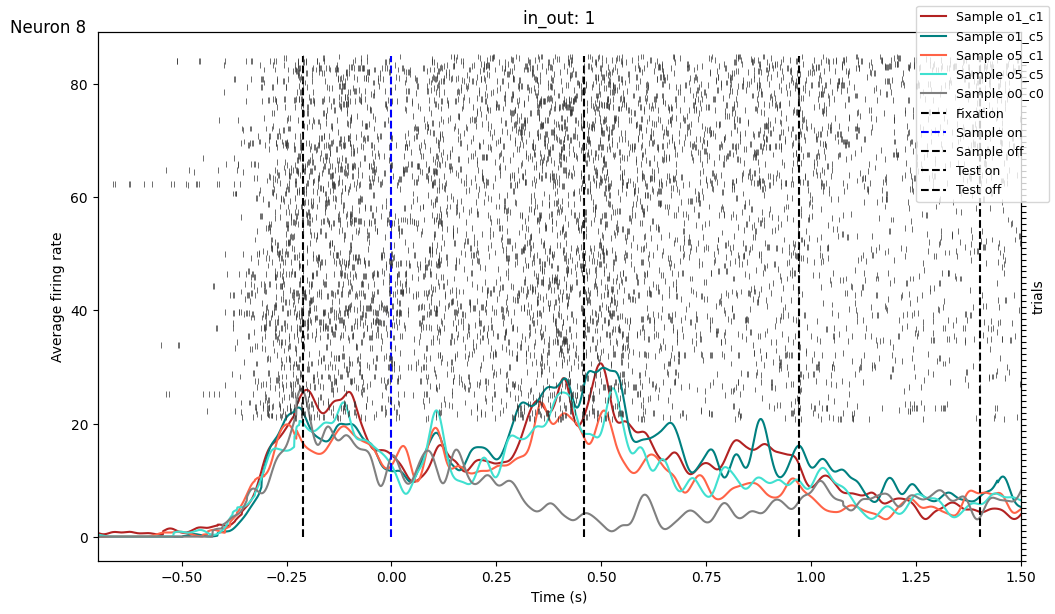

In [50]:
x_lim_max = 1.5
x_lim_min = -0.7
neurons = np.where(sp_py['clustersgroup']=='good')[0]
in_out=1
e_align = 2
samples = ['o1_c1','o1_c5','o5_c1','o5_c5','o0_c0']
fr_samples,neuron_max_shift = mean_fr_by_sample(sp_py,task,samples,events,neurons,in_out,e_align=e_align,fs=config.FS,downsample=config.DOWNSAMPLE,x_lim_min=x_lim_min,x_lim_max=x_lim_max)

## Stats

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score,StratifiedKFold
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from statsmodels.stats.multitest import multipletests
from sklearn.multiclass import OneVsRestClassifier
from statsmodels import api as sm
from statsmodels.formula.api import ols
from bioinfokit. analys import stat as bk_stat
from sklearn.metrics import roc_auc_score
seed = 2023

In [ ]:
n_neuron = 8

## SVM

#### def functions

In [ ]:
def run_svm_decoder(model,list_df,n_iterations,steps,win_steps,win_size,it_seed,resample_value):
    scores = np.zeros((n_iterations,steps))
    for n_it in np.arange(n_iterations):
        #  select trials randomly
        df = []
        for i_df in list_df:
            df.append(i_df.sample(resample_value,random_state=it_seed[n_it],replace=False)) # sample without replacement
        df = pd.concat(df).reset_index(drop=True)
        
        #df = df.sample(frac=1,random_state=it_seed[n_it],replace=False)
        
        X = df.iloc[:, :-4] 
        #X = pd.DataFrame(scaler.fit_transform(X))
        y = df['label_encoder']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,shuffle=True, random_state=it_seed[n_it])
        X_train['label_encoder'] = y_train
        #X_test['label_encoder'] = y_test
        # Sample with replacement
        X_train = X_train.sample(len(X_train),random_state=it_seed[n_it],replace=False)
        y_train = X_train['label_encoder']
        X_train = X_train.iloc[:,:-1]
        for n,n_win in enumerate(np.arange(0,steps*win_steps,win_steps)):
            # Split into X and y
            scaler = MinMaxScaler()
            X = X_train.iloc[:,int(n_win):int(n_win)+win_size].mean(axis=1).values.reshape(-1, 1)
            X = pd.DataFrame(scaler.fit_transform(X))    
            # test
            X_t = X_test.iloc[:,int(n_win):int(n_win)+win_size].mean(axis=1).values.reshape(-1, 1)        
            X_t = pd.DataFrame(scaler.transform(X_t))
            model.fit(X,y_train)
            y_predict = model.predict(X_t)
            scores[n_it, n] = metrics.accuracy_score(y_test,y_predict)# cross_val_score(model, X, y, cv=kf,n_jobs=-1).mean()
    return scores

In [ ]:
# plot results
def plot_accuracy(scores,win_steps,neuron_max_shift,x_lim_min,x_lim_max,n_neuron):
    fig,ax = plt.subplots()
    ax.plot(((np.arange(0,len(scores[0]))*win_steps)- neuron_max_shift[n_neuron-1])/1000,scores[:13].mean(axis=0))
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.vlines(
        0, 0.3, 1, color="k", linestyles="dashed"
    )# sample on
    ax.hlines(
        0.5, x_lim_min, x_lim_max, color="gray", linestyles="solid"
    )
    ax.set_title('Is neuron %d engaged in the task?'%(n_neuron))
    ax.set(xlabel="Time (s)", ylabel="SVM classifier accuracy")
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    fig.legend(['Accuracy','Sample on'], fontsize=9)

#### Model

In [ ]:
# define model
model=  SVC(kernel='linear',C=20,decision_function_shape='ovr',gamma=0.001)
# data preparation
neuron_fr = fr_samples[fr_samples['neuron']== n_neuron]
n_iterations = 10
win_steps = 10
win_size = 100
steps = int(np.ceil((len(neuron_fr.columns[:-4])/win_steps)))
rng = np.random.default_rng(seed=seed)
it_seed = rng.integers(low=1, high=2023, size=n_iterations, dtype=int)

In [ ]:
# encode labels
le = LabelEncoder()
le.fit(neuron_fr['sample'].replace(['B','C','D'],'A').values)
neuron_fr['label_encoder'] = le.transform(neuron_fr.loc[:,'sample'].replace(['B','C','D'],'A').values) # encode labels
# Resample dataframe
resample_value = neuron_fr[neuron_fr['sample']=='N']['sample'].value_counts().min()
list_df=[neuron_fr[(neuron_fr['sample'] == 'A') | (neuron_fr['sample'] == 'B') | (neuron_fr['sample'] == 'C') | (neuron_fr['sample'] == 'D')],neuron_fr[neuron_fr['sample'] == 'N']]

/tmp/ipykernel_13506/3132598917.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuron_fr['label_encoder'] = le.transform(neuron_fr.loc[:,'sample'].replace(['B','C','D'],'A').values) # encode labels


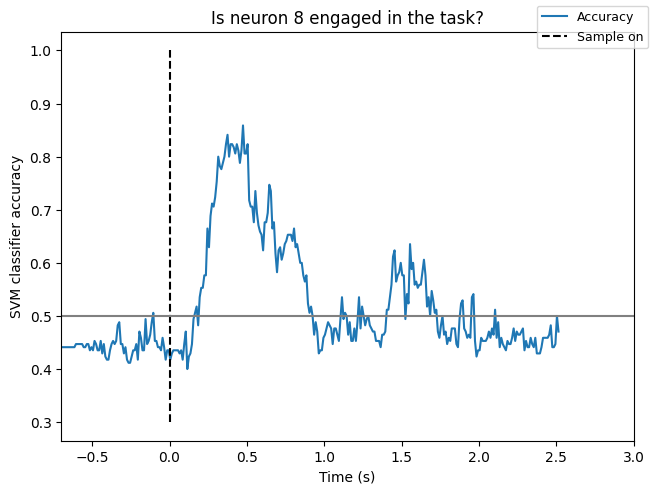

In [ ]:
scores = run_svm_decoder(model,list_df,n_iterations,steps,win_steps,win_size,it_seed,resample_value)
plot_accuracy(scores,win_steps,neuron_max_shift,x_lim_min,x_lim_max,n_neuron)

#### Predict samples

In [ ]:
# encode labels
le = LabelEncoder()
le.fit(neuron_fr['sample'].values)
neuron_fr['label_encoder'] = le.transform(neuron_fr['sample'].values) # encode labels
# Resample dataframe
resample_value = neuron_fr['sample'].value_counts().min()
list_df=[neuron_fr[neuron_fr['sample'] == 'A'],neuron_fr[neuron_fr['sample'] == 'B'],neuron_fr[neuron_fr['sample'] == 'C'],neuron_fr[neuron_fr['sample'] == 'D'],neuron_fr[neuron_fr['sample'] == 'N']]

/tmp/ipykernel_13506/1346663782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuron_fr['label_encoder'] = le.transform(neuron_fr['sample'].values) # encode labels


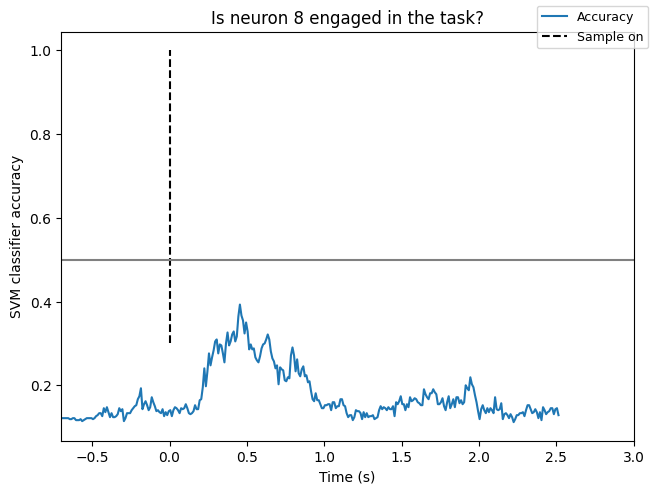

In [ ]:
scores_samples = run_svm_decoder(model,list_df,n_iterations,steps,win_steps,win_size,it_seed,resample_value)
plot_accuracy(scores_samples,win_steps,neuron_max_shift,x_lim_min,x_lim_max,n_neuron)

## ANOVA

#### def functions

In [ ]:
def select_from_df(df1,samples,n_neuron,df2=np.nan):
    if isinstance(df2,pd.DataFrame) == False:
        df2=df1
    # add to check shapes of df1 == df2
    sample_df = []
    for s in samples:
        sample_df.append(df1[(df2['sample']==s)&(df2['neuron']==n_neuron)])
    return pd.concat(sample_df,axis=0)

In [ ]:
# t_test
def compute_f_oneway(group1,group2,group3,group4,neuron_max_shift,seed):
    foneway:Dict[str,list] = defaultdict(list)
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=2023, size=group1.shape[1], dtype=int)
    for n_win in np.arange(group1.shape[1]):
        trials_group1 = group1.iloc[:,n_win]
        trials_group2 = group2.iloc[:,n_win]
        trials_group3 = group3.iloc[:,n_win]
        trials_group4 = group4.iloc[:,n_win]
        #trials_group5 = group5.iloc[:,n_win]
        p=stats.f_oneway(trials_group1.values, trials_group2.values,trials_group3.values, trials_group4.values)#,trials_group5.values)
        foneway['p']+=[p[1]]
        
    foneway=pd.DataFrame(foneway)
    fig,ax=plt.subplots(figsize=(10,3))
    bonferroni_foneway = multipletests(foneway.values.reshape(-1),alpha=0.05)[1]
    mask_b = bonferroni_foneway<0.05
    mask_f = foneway.values.reshape(-1)<0.05
    ax.plot((np.arange(len(foneway))-neuron_max_shift[0]/step)/1000,foneway.values.reshape(-1))
    ax.scatter(((np.arange(len(foneway))-neuron_max_shift[0]/step)/1000)[mask_f],foneway.values.reshape(-1)[mask_f],c='b',marker='.')
    ax.plot((np.arange(len(foneway))-neuron_max_shift[0]/step)/1000,bonferroni_foneway)
    ax.scatter(((np.arange(len(foneway))-neuron_max_shift[0]/step)/1000)[mask_b],bonferroni_foneway[mask_b],c='firebrick',marker='.')

    return foneway

#### compute anova

In [ ]:
neuron_fr = fr_samples[fr_samples['neuron']== n_neuron]
win_size = 500
step = 1
fix_duration = 100
mean_fr_window = neuron_fr.iloc[:, :-3].rolling(window = win_size,axis=1,step=step,min_periods=1).mean()

/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3906: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


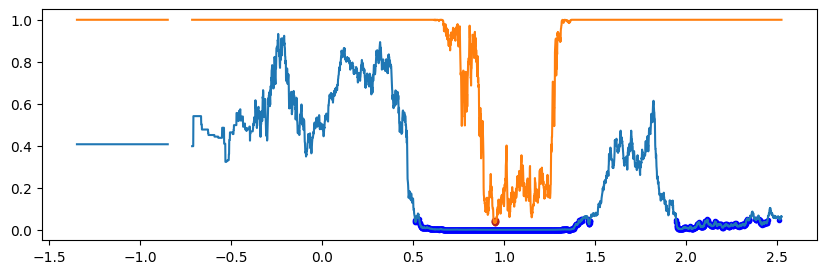

In [ ]:
a = select_from_df(df1=mean_fr_window,samples=['A'],n_neuron=n_neuron,df2=neuron_fr)
b = select_from_df(df1=mean_fr_window,samples=['B'],n_neuron=n_neuron,df2=neuron_fr)
c = select_from_df(df1=mean_fr_window,samples=['C'],n_neuron=n_neuron,df2=neuron_fr)
d = select_from_df(df1=mean_fr_window,samples=['D'],n_neuron=n_neuron,df2=neuron_fr)
#n = select_from_df(df1=mean_fr_window,samples=['N'],n_neuron=n_neuron,df2=neuron_fr)
foneway = compute_f_oneway(a,b,c,d,neuron_max_shift,seed)


## t test

#### def functions

In [ ]:
# t_test
def compute_t_test(group1,group2,neuron_max_shift,seed):
    t_test:Dict[str,list] = defaultdict(list)
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=2023, size=group1.shape[1], dtype=int)
    for n_win in np.arange(group1.shape[1]):
        trials_group1 = group1.iloc[:,n_win]
        trials_group2 = group2.iloc[:,n_win]
        p=stats.ttest_ind(trials_group1.values, trials_group2.values)
        t_test['p']+=[p[1]]
        
    t_test=pd.DataFrame(t_test)
    fig,ax=plt.subplots(figsize=(10,3))
    bonferroni_t_test = multipletests(t_test.values.reshape(-1),alpha=0.05)[1]
    mask_b = bonferroni_t_test<0.05
    mask_t = t_test.values.reshape(-1)<0.05
    ax.plot((np.arange(len(t_test))-neuron_max_shift[0]/step)/1000,t_test.values.reshape(-1))
    ax.scatter(((np.arange(len(t_test))-neuron_max_shift[0]/step)/1000)[mask_t],t_test.values.reshape(-1)[mask_t],c='b',marker='.')
    ax.plot((np.arange(len(t_test))-neuron_max_shift[0]/step)/1000,bonferroni_t_test)
    ax.scatter(((np.arange(len(t_test))-neuron_max_shift[0]/step)/1000)[mask_b],bonferroni_t_test[mask_b],c='firebrick',marker='.')
    ax.set(xlabel="Time (s)", ylabel="p-value")
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    fig.legend(['t-test','values under 0.05','bonferroni','values under 0.05'], fontsize=8)
    return t_test


#### compute t-test

In [ ]:
neuron_fr = fr_samples[fr_samples['neuron']== n_neuron]
win_size = 500
step = 1
fix_duration = 100
mean_fr_window = neuron_fr.iloc[:, :-3].rolling(window = win_size,axis=1,step=step,min_periods=1).mean()

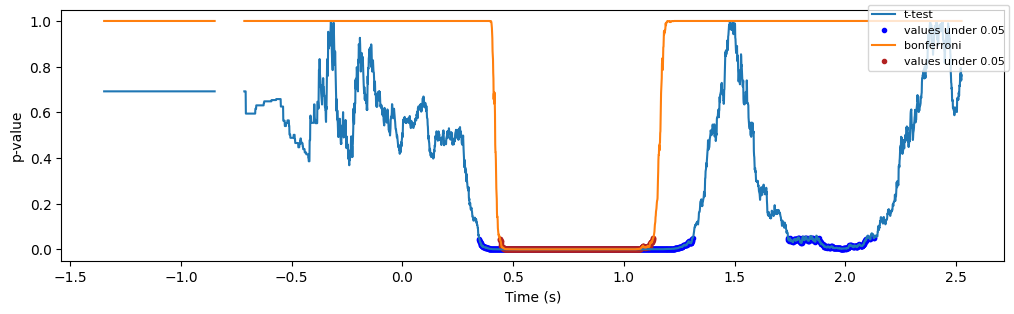

In [ ]:
# test whether the neuron is engaged in the task (N vs others)
all_sample_presentation = select_from_df(df1=mean_fr_window,samples=['A','B','C','D'],n_neuron=n_neuron,df2=neuron_fr)
n_sample_presentation = select_from_df(df1=mean_fr_window,samples=['N'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(all_sample_presentation,n_sample_presentation,neuron_max_shift,seed)

#### Check if it is sample selective
The neuron is sample selective only if it is significant for one of the following (a vs d | b vs c):

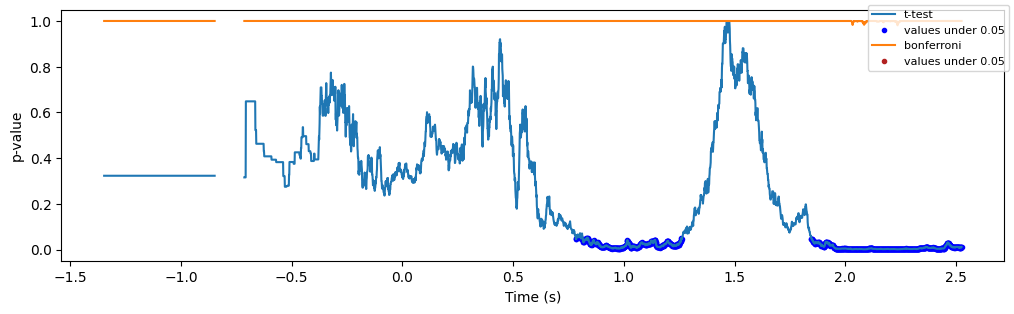

In [ ]:
# Color - orientation 1
a = select_from_df(df1=mean_fr_window,samples=['A'],n_neuron=n_neuron,df2=neuron_fr)
d = select_from_df(df1=mean_fr_window,samples=['D'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(a,d,neuron_max_shift,seed)

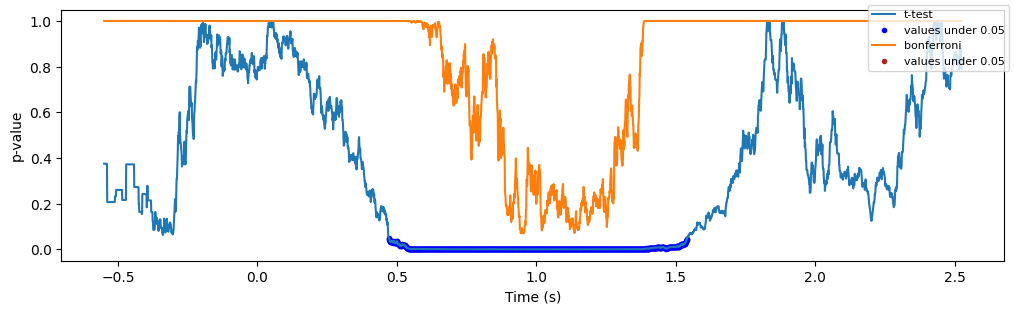

In [ ]:
# Color - orientation 2 
b = select_from_df(df1=mean_fr_window,samples=['B'],n_neuron=n_neuron,df2=neuron_fr)
c = select_from_df(df1=mean_fr_window,samples=['C'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(b,c,neuron_max_shift,seed)

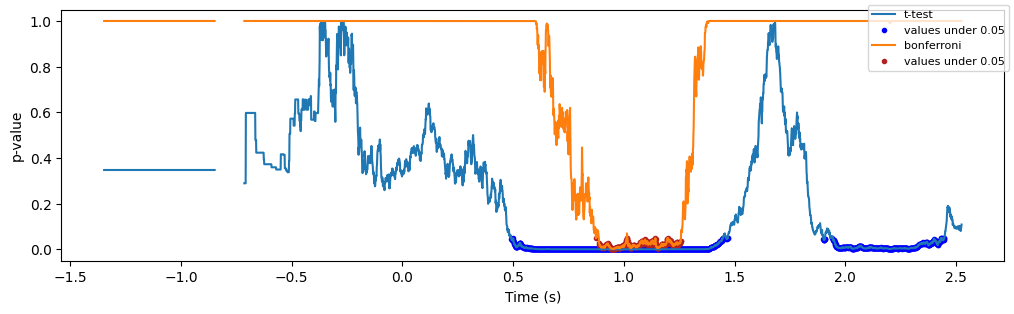

In [ ]:
# Orientation 
ab = select_from_df(df1=mean_fr_window,samples=['A','B'],n_neuron=n_neuron,df2=neuron_fr)
cd = select_from_df(df1=mean_fr_window,samples=['C','D'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(ab,cd,neuron_max_shift,seed)

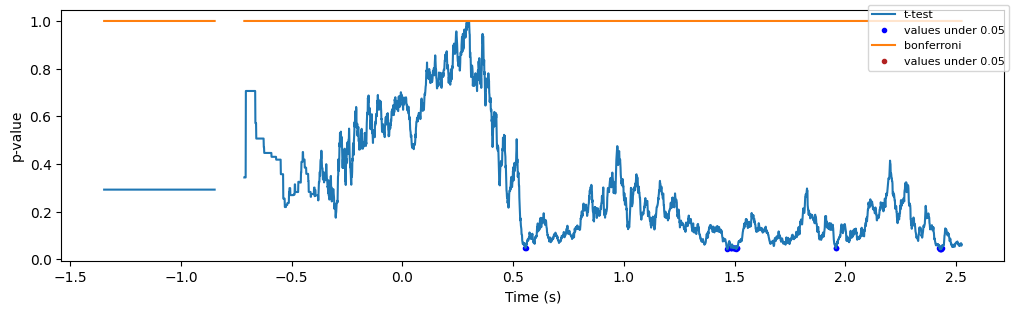

In [ ]:
# Color
ac = select_from_df(df1=mean_fr_window,samples=['A','C'],n_neuron=n_neuron,df2=neuron_fr)
bd = select_from_df(df1=mean_fr_window,samples=['B','D'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(ac,bd,neuron_max_shift,seed)

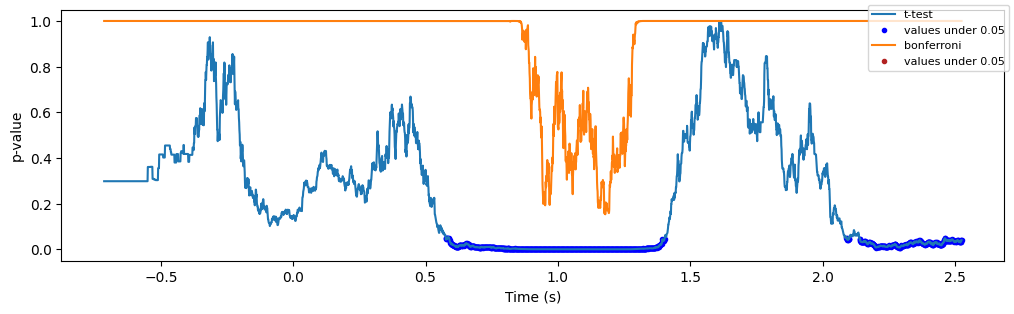

In [ ]:
# A vs C (same color)
a = select_from_df(df1=mean_fr_window,samples=['A'],n_neuron=n_neuron,df2=neuron_fr)
c = select_from_df(df1=mean_fr_window,samples=['C'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(a,c,neuron_max_shift,seed)

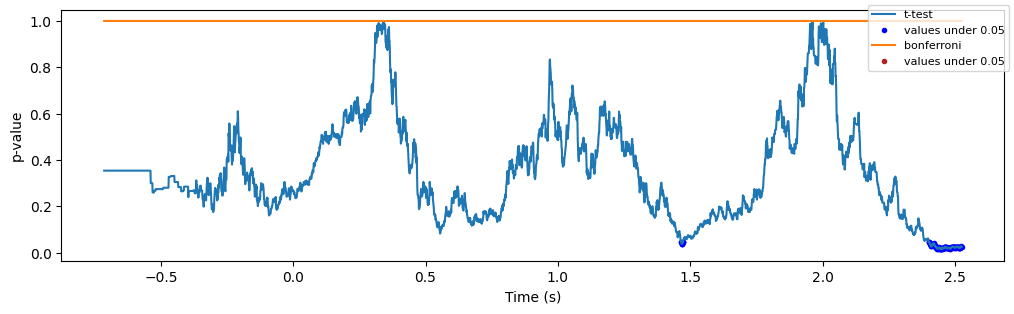

In [ ]:
# A vs B (same orientation)
a = select_from_df(df1=mean_fr_window,samples=['A'],n_neuron=n_neuron,df2=neuron_fr)
b = select_from_df(df1=mean_fr_window,samples=['B'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(a,b,neuron_max_shift,seed)

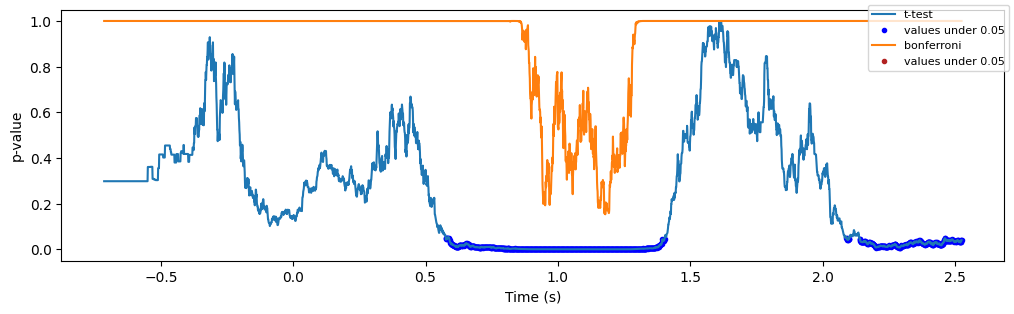

In [ ]:
# C vs D (same orientation)
c = select_from_df(df1=mean_fr_window,samples=['C'],n_neuron=n_neuron,df2=neuron_fr)
d = select_from_df(df1=mean_fr_window,samples=['D'],n_neuron=n_neuron,df2=neuron_fr)
t_test=compute_t_test(a,c,neuron_max_shift,seed)

## index

#### Def functions

In [ ]:
# index
def compute_index(group1,group2,neuron_max_shift,seed):
    index:Dict[str,list] = defaultdict(list)
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=2023, size=group1.shape[1], dtype=int)
    for n_win in np.arange(group1.shape[1]):
        trials_group1 = group1.iloc[:,n_win]
        trials_group2 = group2.iloc[:,n_win]
        if trials_group1.mean!=0 or trials_group2.mean()!=0:
            if trials_group1.mean()>trials_group2.mean():
                pref = trials_group1
                n_pref = trials_group2
                g=0
            else:
                pref = trials_group2
                n_pref = trials_group1 
                g=1
            index['idx']+=[(pref.mean()-n_pref.mean())/(pref.mean()+n_pref.mean())]#np.sqrt((pref.var()+n_pref.var())/2)
            index['group'] += [g]
        else:
            index['idx']+=[0]
            index['group'] += [0.5]
        
    index=pd.DataFrame(index)
    fig,ax=plt.subplots(figsize=(10,3))
    ax.plot((np.arange(len(index))-neuron_max_shift[0]/step)/1000,index['idx'].values.reshape(-1))
    ax.plot((np.arange(len(index))-neuron_max_shift[0]/step)/1000,index['group'].values.reshape(-1))    
    return index

#### Compute index

/tmp/ipykernel_13506/2578455449.py:18: RuntimeWarning: invalid value encountered in scalar divide
  index['idx']+=[(pref.mean()-n_pref.mean())/(pref.mean()+n_pref.mean())]#np.sqrt((pref.var()+n_pref.var())/2)


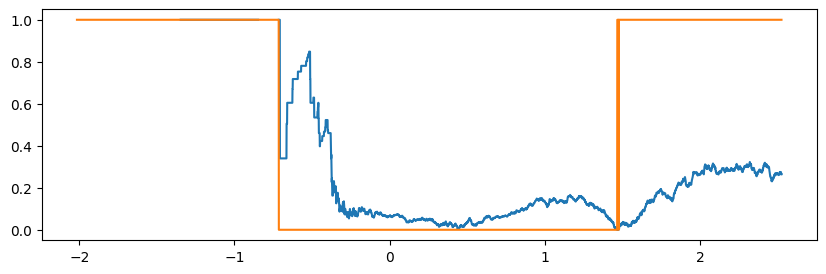

In [ ]:
index=compute_index(a,d,neuron_max_shift,seed)

## ROC AUC score

#### Def functions

In [ ]:
def compute_roc_auc(group1,group2):
    roc_score:Dict[str,list] = defaultdict(list)
    rng = np.random.default_rng(seed=seed)
    it_seed = rng.integers(low=1, high=2023, size=a.shape[1], dtype=int)
    for n_win in np.arange(a.shape[1]):
        g1 = group1.iloc[:,n_win]
        g2 = group2.iloc[:,n_win]
        min_fr, max_fr = pd.concat((g1,g2)).min(),pd.concat((g1,g2)).max()
        thresholds = np.arange(min_fr,max_fr+0.01,0.01)
        y_g1, y_g2 = np.ones(len(g1)),np.zeros(len(g2))
        score=0
        fpr,tpr=[],[]
        for threshold in thresholds:
            g1_y_pred,g2_y_pred = np.zeros(len(g1)),np.zeros(len(g2))
            g1_mask,g2_mask = g1.values>=threshold,g2.values>=threshold
            g1_y_pred[g1_mask],g2_y_pred[g2_mask] = 1,1
            tp = sum(np.logical_and(y_g1==1,g1_y_pred==1))
            fn = sum(np.logical_and(y_g1==1,g1_y_pred==0))
            tpr.append(tp/ (tp+fn) )
            fp = sum(np.logical_and(y_g2==0,g2_y_pred==1))
            tn = sum(np.logical_and(y_g2==0,g2_y_pred==0))
            fpr.append(fp/ (fp+tn) )
        if len(fpr) > 1:
            fpr,tpr=np.array(fpr),np.array(tpr)
            idx_sort=fpr.argsort()
            score = metrics.auc(fpr[idx_sort],tpr[idx_sort])
            roc_score['score']+=[score]
        else:
            roc_score['score']+=[0.5]
    roc_score=pd.DataFrame(roc_score)
    fig,ax=plt.subplots(figsize=(10,3))
    ax.plot((np.arange(len(roc_score))-neuron_max_shift[0]/step)/1000,roc_score['score'].values.reshape(-1))   
    ax.set(xlabel="Time (s)", ylabel="ROC AUC score")
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.2)
    
    return roc_score


#### Compute roc

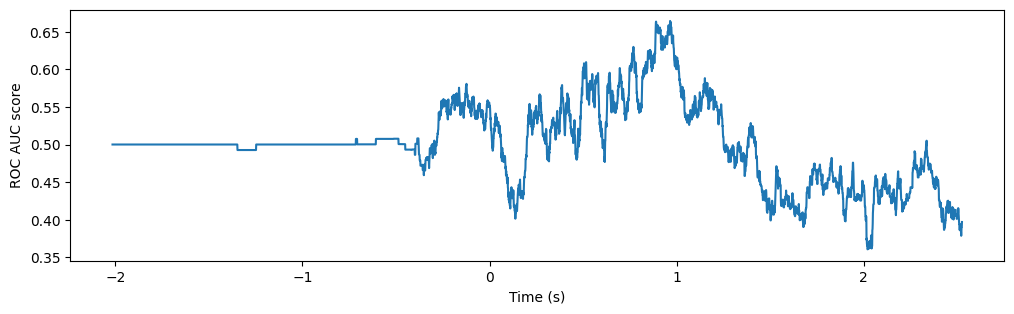

In [ ]:
neuron_fr = fr_samples[fr_samples['neuron']== n_neuron]
win_size = 100
step = 1
fix_duration = 100
mean_fr_window = neuron_fr.iloc[:, :-3].rolling(window = win_size,axis=1,step=step,min_periods=1).mean()
a = select_from_df(df1=mean_fr_window,samples=['A'],n_neuron=n_neuron,df2=neuron_fr)
d = select_from_df(df1=mean_fr_window,samples=['D'],n_neuron=n_neuron,df2=neuron_fr)
roc_score =compute_roc_auc(a,d)

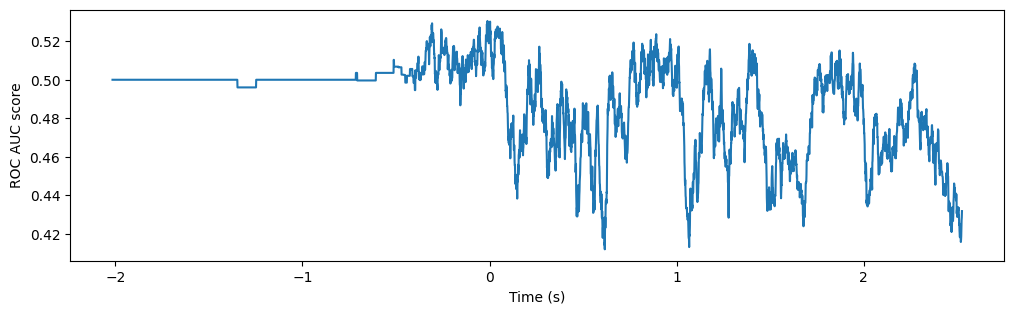

In [ ]:
ac = select_from_df(df1=mean_fr_window,samples=['A','C'],n_neuron=n_neuron,df2=neuron_fr)
bd = select_from_df(df1=mean_fr_window,samples=['B','D'],n_neuron=n_neuron,df2=neuron_fr)
roc_score = compute_roc_auc(ac,bd)